***Forecasting the number of antidiabetic drug prescriptions in Australia***

The objective of the project is to forecast the number of antidiabetic drug prescriptions in Australia, from 1991 to 2008.

To solve this problem, refer to the following steps:

- The objective is to forecast 12 months of antidiabetic drug prescriptions. Use the last 36 months of the dataset as a test set to allow for rolling forecasts.
- Visualize the time series.
- Use time series decomposition to extract the trend and seasonal components.
- Based on your exploration, determine the most suitable model.
- Model the series with the usual steps:
  - Apply transformations to make it stationary
  - Set the values of d and D. Set the value of m.
  - Find the optimal (p,d,q)(P,D,Q)m parameters.
  - Perform residual analysis to validate your model.
- Perform rolling forecasts of 12 months on the test set.
- Visualize your forecasts.
- Compare the model’s performance to a baseline. Select an appropriate baseline and error metric.
- Conclude whether the model should be used or not.

In [40]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

from itertools import product
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# loading dataset

url = 'https://github.com/marcopeix/TimeSeriesForecastingInPython/raw/master/data/AusAntidiabeticDrug.csv'
df = pd.read_csv(url)

***Data exploration***

In [3]:
# looking at the first rows of the dataset

df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
# looking at missing values and dtypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      204 non-null    object 
 1   y       204 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


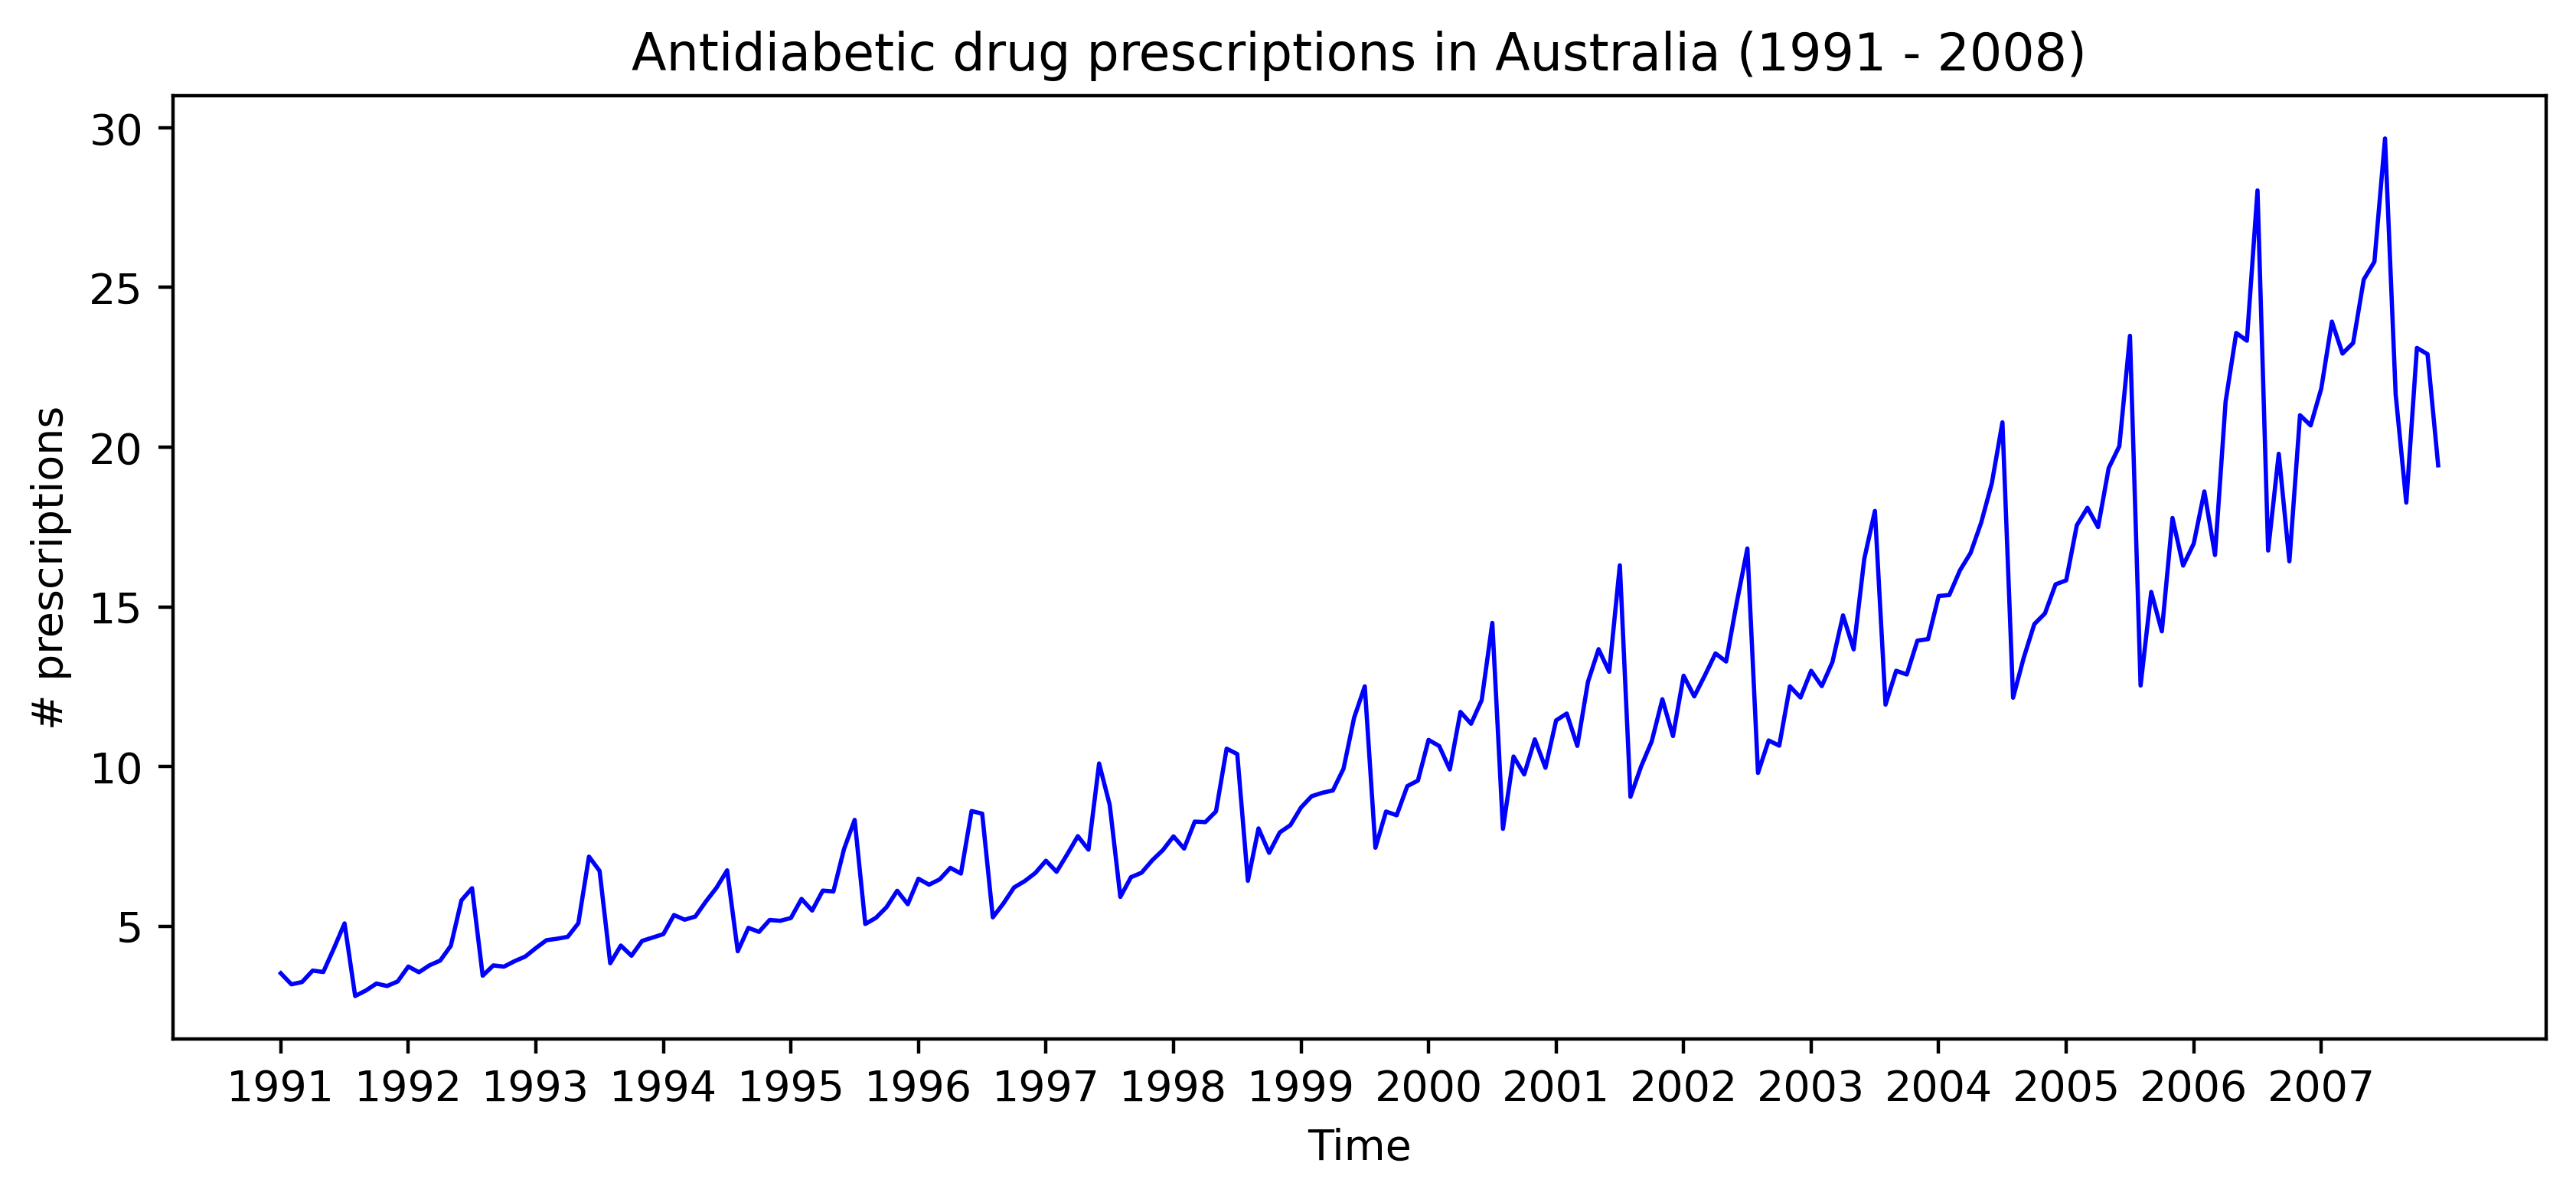

In [14]:
# plotting the series

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df.ds, df.y, 'b', linewidth= 1)

# customizing the plot
ax.set(title='Antidiabetic drug prescriptions in Australia (1991 - 2008)', ylabel='# prescriptions', xlabel='Time')
plt.xticks(
    range(0, 204, 12),
    range(1991, 2008)
);

***Extracting the individual components of the series***

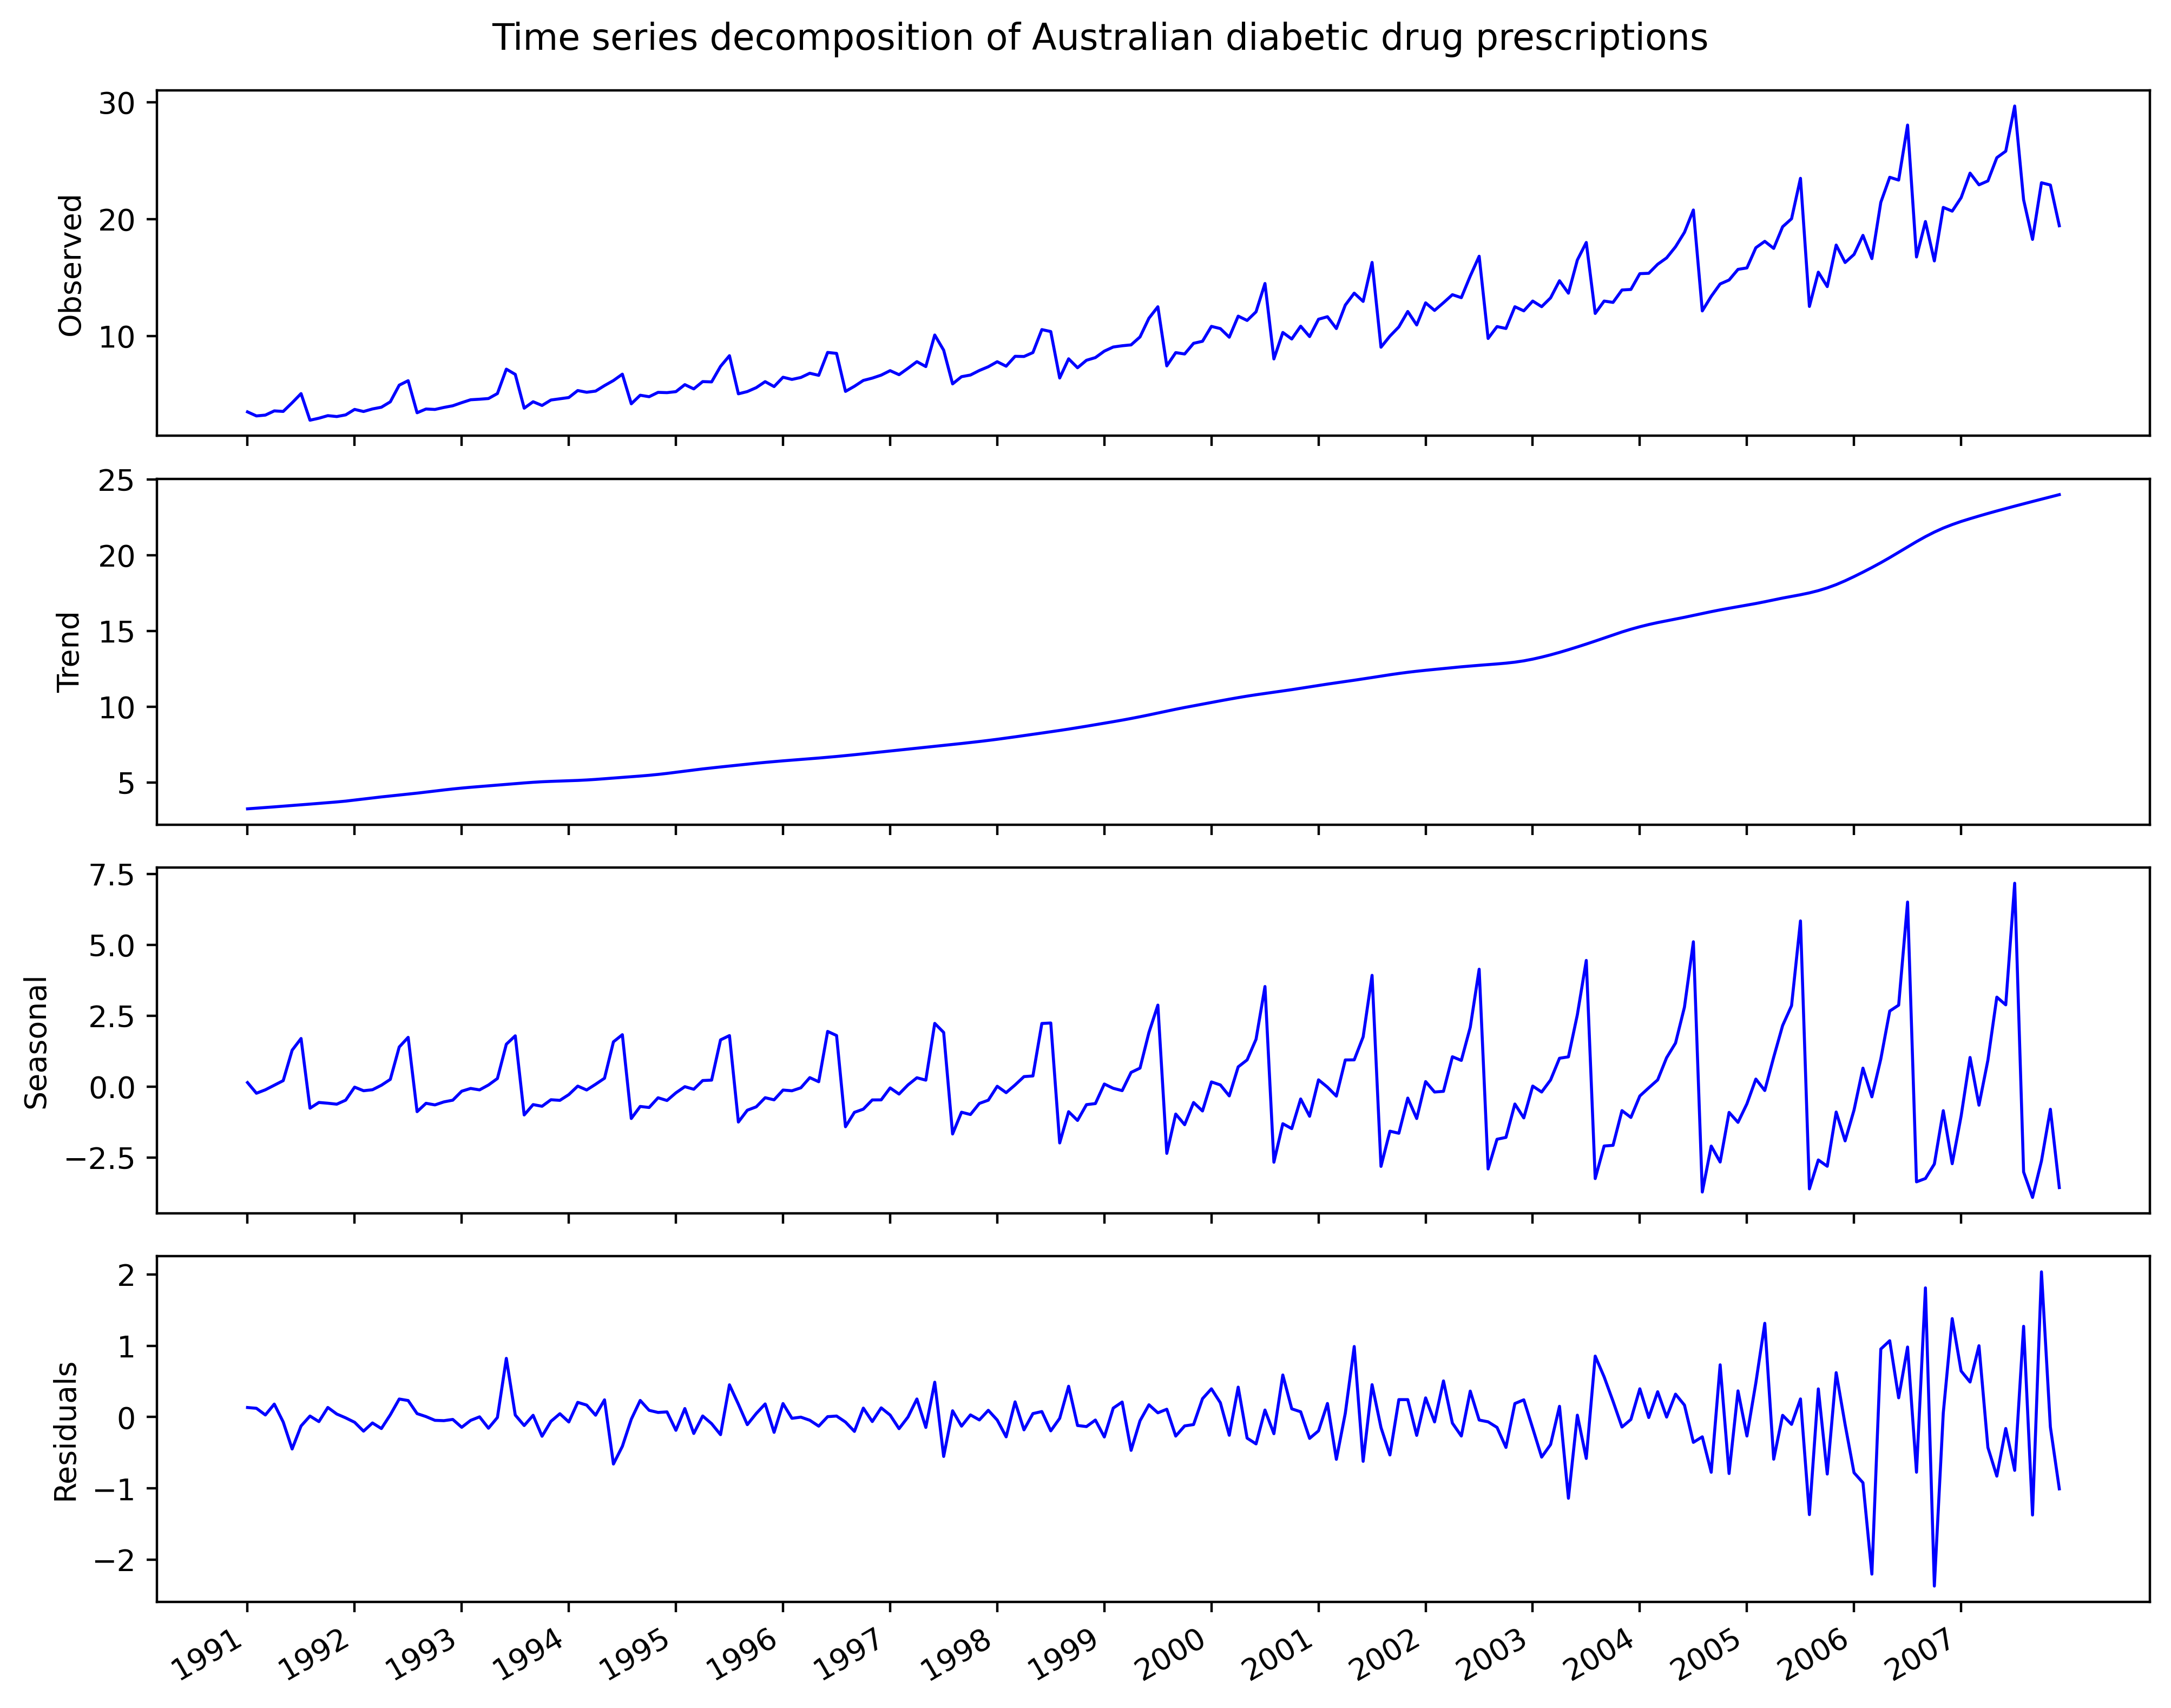

In [22]:
# plotting the individual components of the series

decomposition = STL(df.y, period= 12).fit()

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex= True)

# plotting the observed values
ax[0].plot(decomposition.observed, 'b', linewidth= 1)
ax[0].set(ylabel='Observed')

# plotting the trend component
ax[1].plot(decomposition.trend, 'b', linewidth= 1)
ax[1].set(ylabel='Trend')

# plotting the seasonal component
ax[2].plot(decomposition.seasonal, 'b', linewidth= 1)
ax[2].set(ylabel='Seasonal')

# plotting the residual component
ax[3].plot(decomposition.resid, 'b', linewidth= 1)
ax[3].set(ylabel='Residuals')

# customizing the plot
plt.xticks(
    range(0, 204, 12),
    range(1991, 2008)
)

fig.suptitle('Time series decomposition of Australian diabetic drug prescriptions')

fig.autofmt_xdate()
plt.tight_layout();

***Determining the most suitable model***

When looking at the decomposition of the time series we can see that there is a clear seasonal component with a period of 12, this indicates the need for a model that can account for seasonality. We can also see that there is a clear upwards trend and therefore the series will have to be differenced, a SARIMA model will be used.

In [24]:
# finding the correct differencing order
# checking first whether the series is stationary

results = True if adfuller(df.y)[1] < .05 else False
results

False

The series is not stationary

In [25]:
# checking the smallest differencing order d after which the series becomes stationary

def stationarity(series, alpha=.05):
    d = 0
    while adfuller(series)[1] > alpha:
        series = np.diff(series, n= 1)
        d += 1
    
    return d

stationarity(df.y)

2

After 2 differentiations the series becomes stationary, however perhaps differencing the series seasonally after one differencing would work too.

In [27]:
# checking whether sesonal differencing on the diff1 series will make it stationary

diff_series = np.diff(df.y, n= 1)
seasonal_diff = np.diff(diff_series, n= 12)

results = adfuller(seasonal_diff)[1] < .05
results

True

We set d to 1 and D to 1, one differencing and one seasonal differencing.

In [30]:
# computing all possible p, q, P and Q combinations

ps = qs = Ps = Qs = range(0, 4, 1)
d, D, s = 1, 1, 12
order_list = list(product(ps, qs, Ps, Qs))

In [34]:
# defining a function to optimize the model's parameters

def optimize_sarima(
        endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int):
    
    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]),
                            seasonal_order=(order[2], D, order[3], s),
                            simple_differencing= False
                            ).fit(disp= False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    results_df = pd.DataFrame(results, columns='(p,q,P,Q) AIC'.split())
    results_df = results_df.sort_values(by='AIC', ascending= True).reset_index(drop= True)

    return results_df
            

In [35]:
# split the data into train and test sets
# we will use the last 36 months of data for testing

train, test = df[:-36], df[-36:]

print(len(train), len(test))

168 36


In [36]:
# computing the model's optimal parameters

results = optimize_sarima(train.y, order_list, d, D, s)
results

  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\nico-\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nico-\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nico-\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nico-\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nico-\AppData\R

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(3, 3, 1, 3)",271.454641
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580413
4,"(3, 3, 2, 0)",272.949440
...,...,...
250,"(0, 0, 3, 1)",351.425175
251,"(0, 0, 1, 1)",351.466837
252,"(0, 0, 0, 1)",354.751719
253,"(0, 0, 1, 0)",357.173706


The model with the lowest AIC is a SARIMA(3, 1, 1)(1, 1, 3, 12).

***Residual analysis***

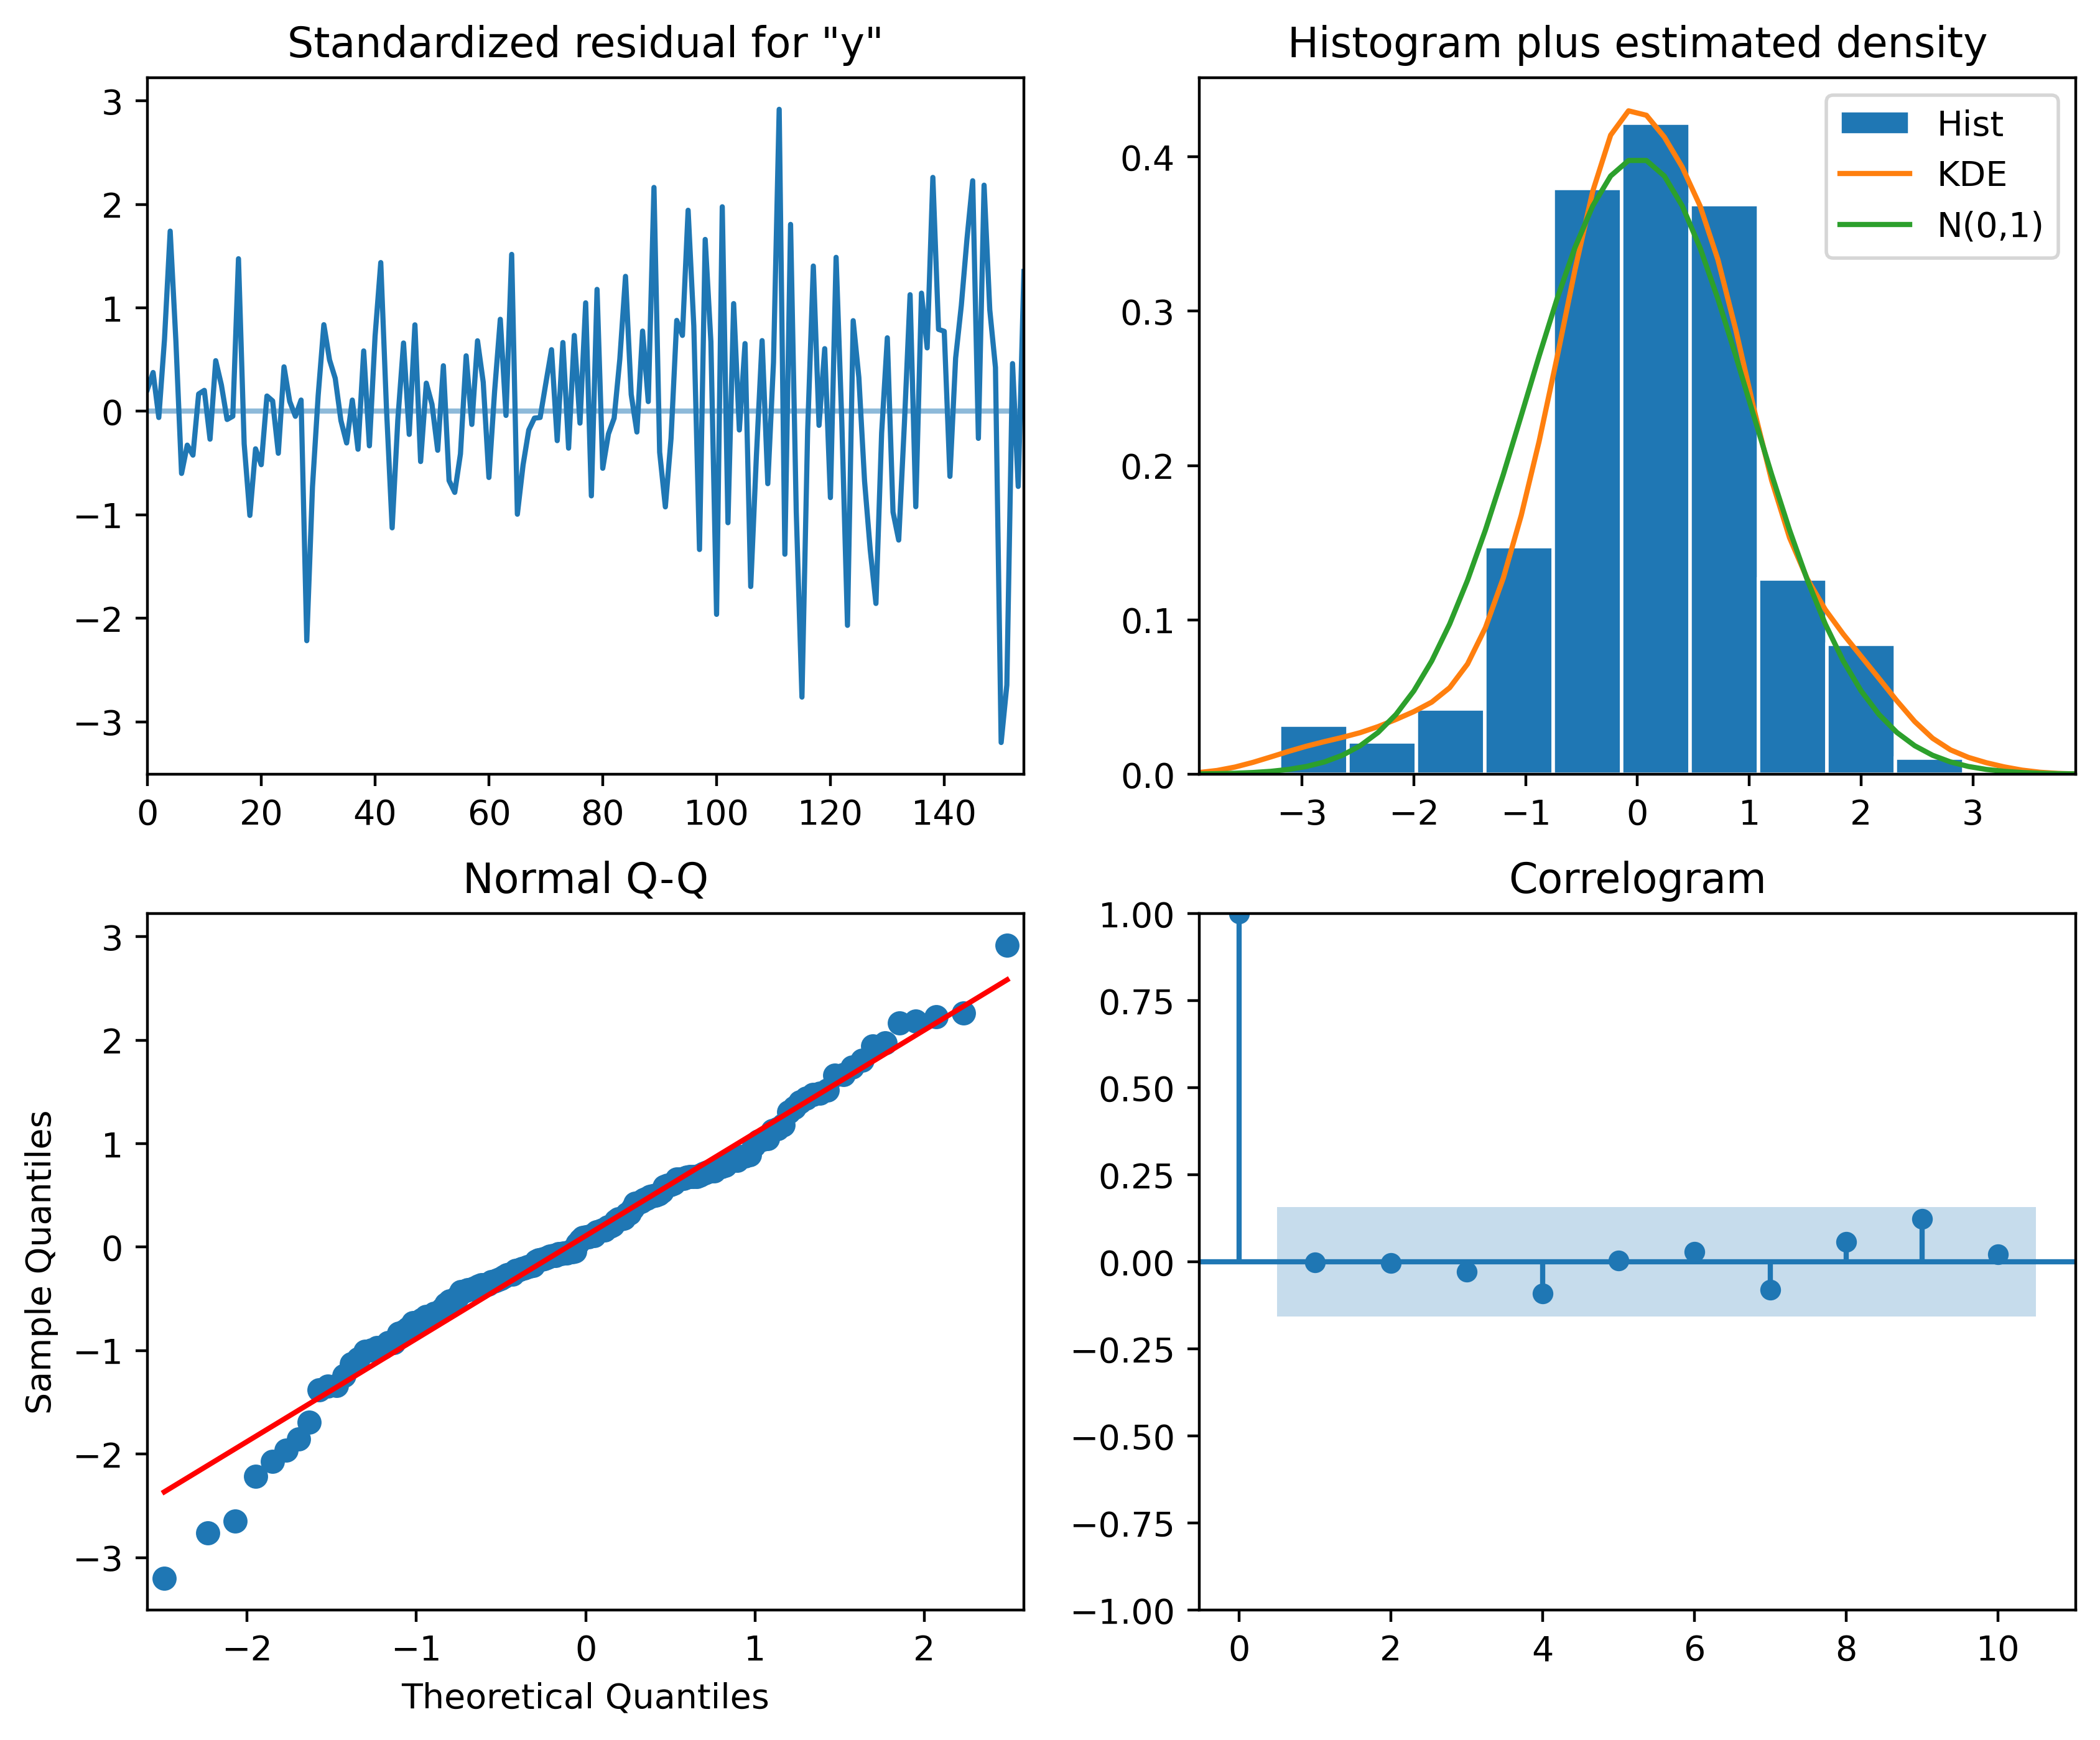

In [38]:
# qualitative residual analysis

model = SARIMAX(train.y, order=(3, 1, 1),
                seasonal_order=(1, 1, 3, 12),
                simple_differencing= False
                ).fit(disp= False)

model.plot_diagnostics(figsize=(10, 8));

We can see that we have removed the trend from the residuals and their variance seems stable, their distribution resembles a normal distribution as it can be seen from both the histogram and the Q-Q plot, and the correlogram shows no significant coefficients after lag 0, just like we would expect from white noise.

In [41]:
# quantitative residual analysis

residuals = model.resid
results = acorr_ljungbox(residuals, lags= np.arange(1, 11, 1), return_df= True)

results

,lb_stat,lb_pvalue
1,0.436939,0.508604
2,0.627648,0.730648
3,0.646149,0.885791
4,2.258432,0.688347
5,2.950692,0.707588
6,3.389678,0.758585
7,9.982199,0.189585
8,10.592183,0.225894
9,11.854350,0.221645
10,11.985648,0.286018


All of the p-values are greater than alpha and therefore we can not reject the null hypothesis and conclude that the residuals are independent and resemble white noise, therefore the model is ready to forecast.

In [56]:
# defining a rolling forecast function

def rolling_forecast(
        df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last_season':
        pred_last = []

        for i in range(train_len, total_len, window):
            last_season = df[i-window:i].values
            pred_last.extend(last_season)

        return pred_last 
    
    elif method == 'SARIMA':
        pred_sarima = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 1, 1),
                            seasonal_order=(1, 1, 3, 12)
                            ).fit(disp= False)
            predictions = model.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_sarima.extend(oos_pred)

        return pred_sarima

In [54]:
# splitting the data into new train and test sets

train, test = df[:-36], df[-36:]

print(len(train), len(test))

168 36


In [80]:
# computing forecasted values

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 12

pred_last = rolling_forecast(df.y, TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_sarima = rolling_forecast(df.y, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

# adding the values to the test dataframe
test.loc[:, 'pred_last'] = pred_last
test.loc[:, 'pred_sarima'] = pred_sarima

test.head()


C:\Users\nico-\AppData\Local\Temp\ipykernel_18368\693422359.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last'] = pred_last
C:\Users\nico-\AppData\Local\Temp\ipykernel_18368\693422359.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_sarima'] = pred_sarima


,ds,y,pred_last,pred_sarima
168,2005-07-01,15.829550,15.339097,16.745821
169,2005-08-01,17.554701,15.370764,16.619319
170,2005-09-01,18.100864,16.142005,17.255308
171,2005-10-01,17.496668,16.685754,18.107520
172,2005-11-01,19.347265,17.636728,18.722180


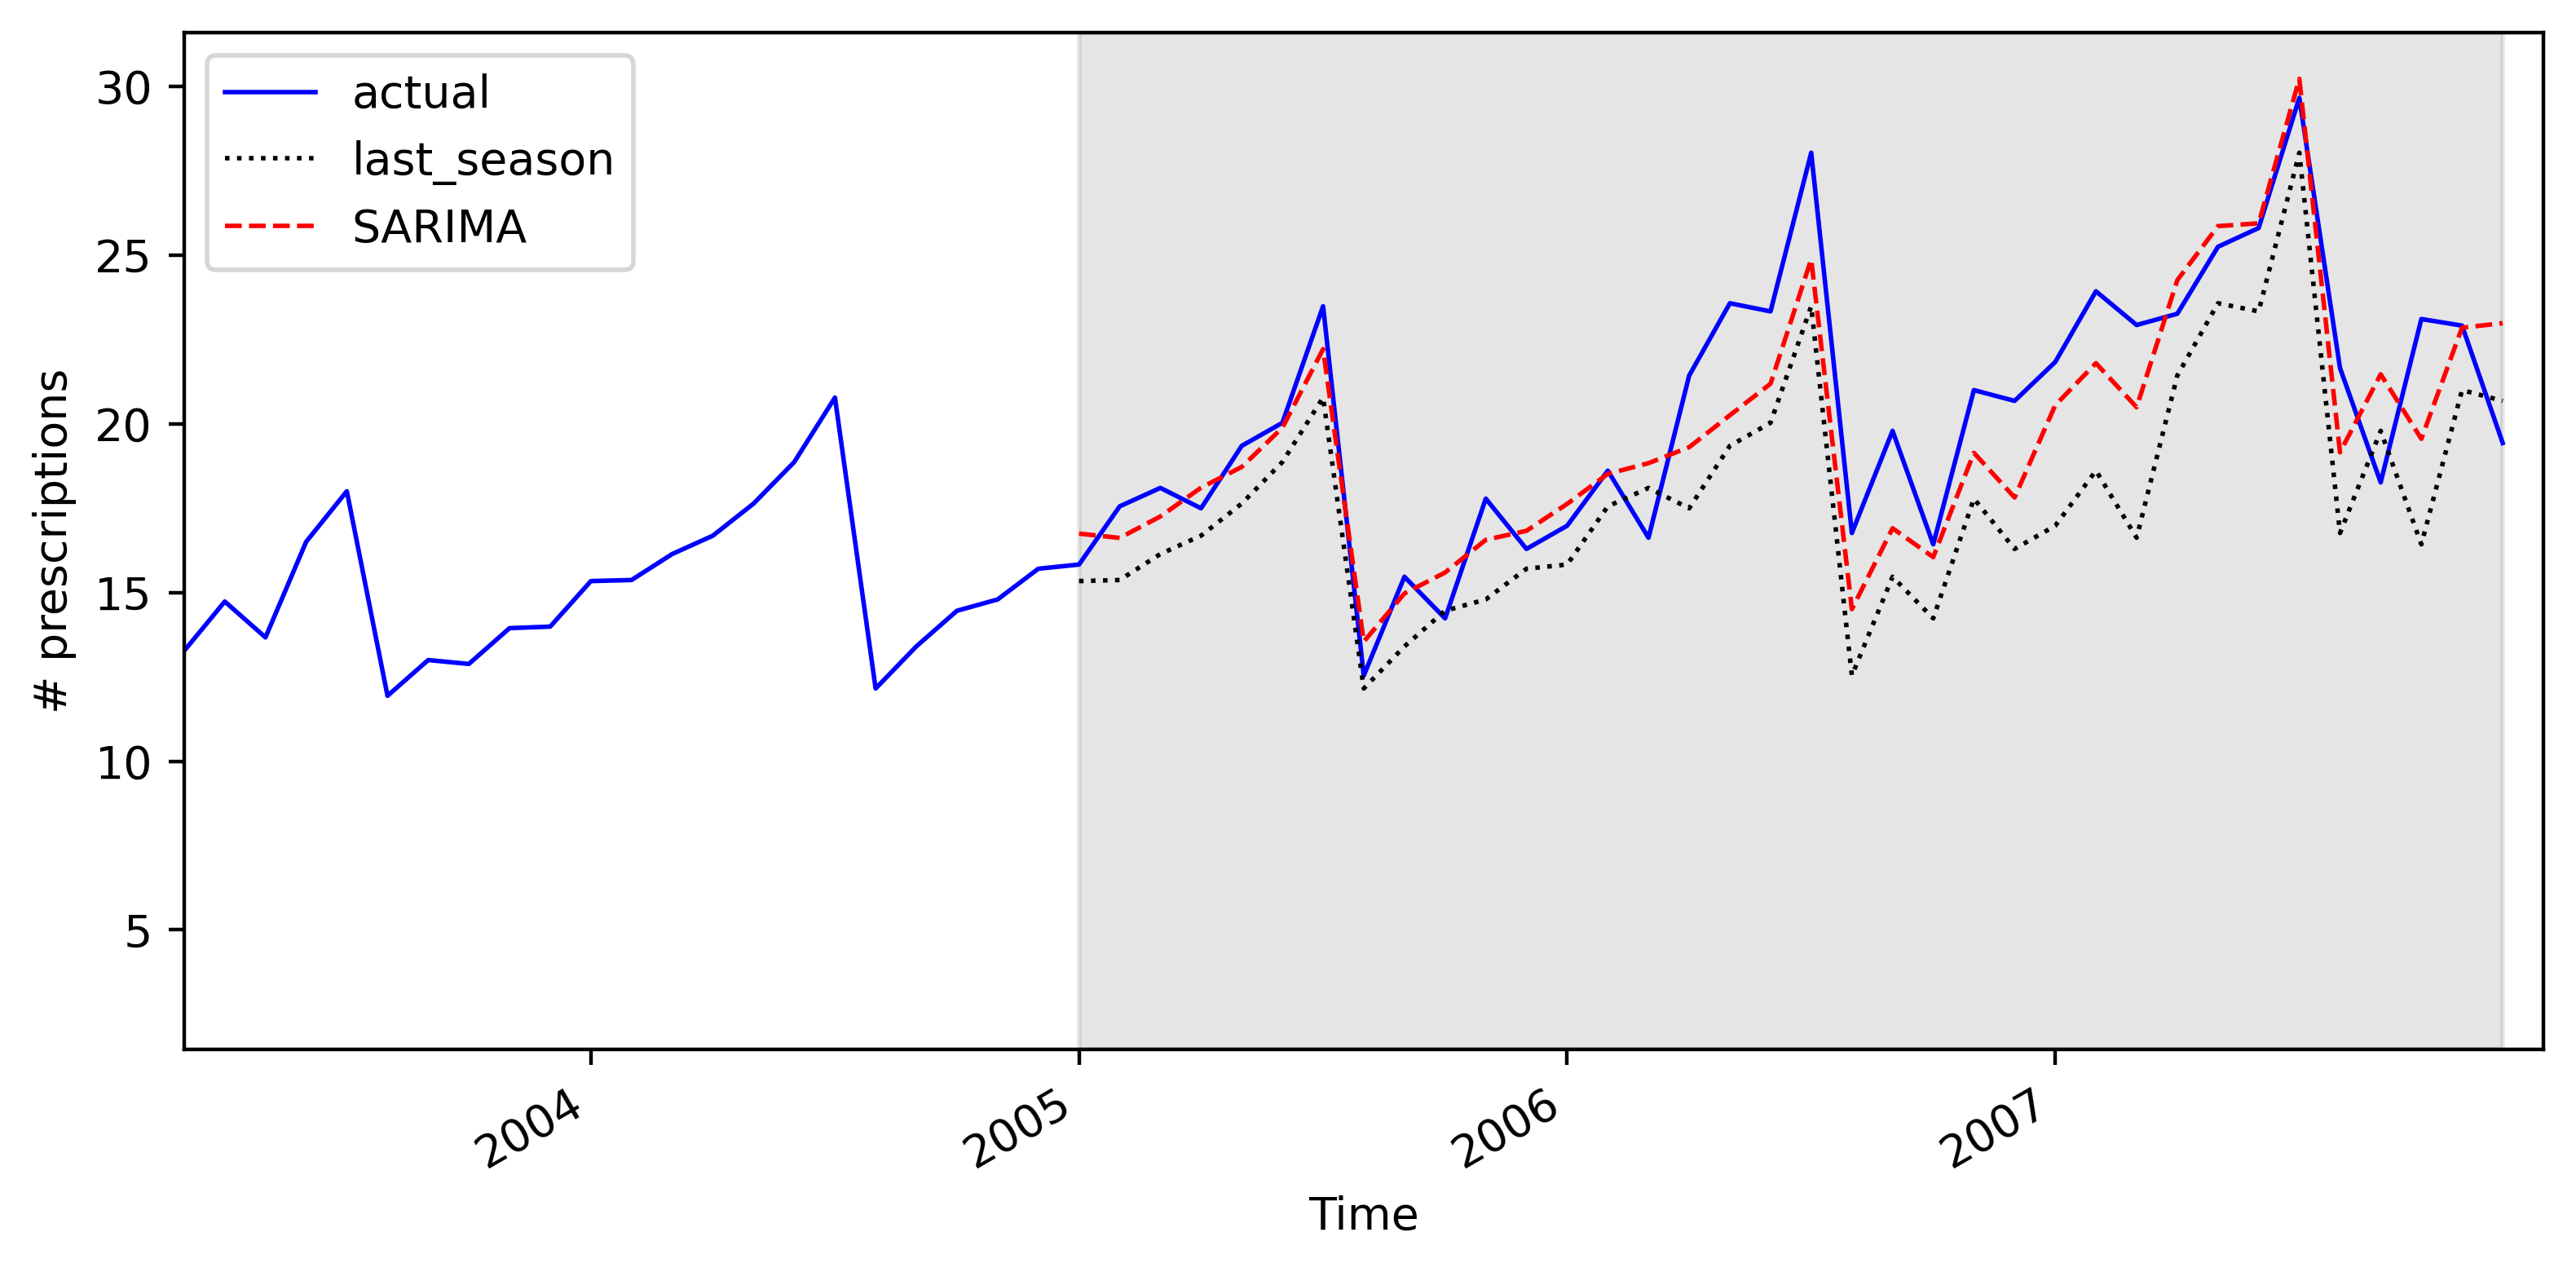

In [81]:
# comparing the forecasted and observed values

fig, ax = plt.subplots(figsize=(8, 4))

# plotting the observed values
ax.plot(df.ds, df.y, 'b', linewidth= 1, label='actual')

# plotting the forecasted values
ax.plot(test.pred_last, 'k:', linewidth= 1, label='last_season')
ax.plot(test.pred_sarima, 'r--', linewidth= 1, label='SARIMA')

# customizing the plot
ax.set(ylabel='# prescriptions', xlabel='Time')
ax.axvspan(168, 203, color='#808080', alpha=.2)

plt.xticks(
    range(0, 204, 12),
    range(1991, 2008)
)

plt.xlim(146, 204)
plt.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout();


In [70]:
# defining a function to calculate the MAPE of each forecasting method

def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

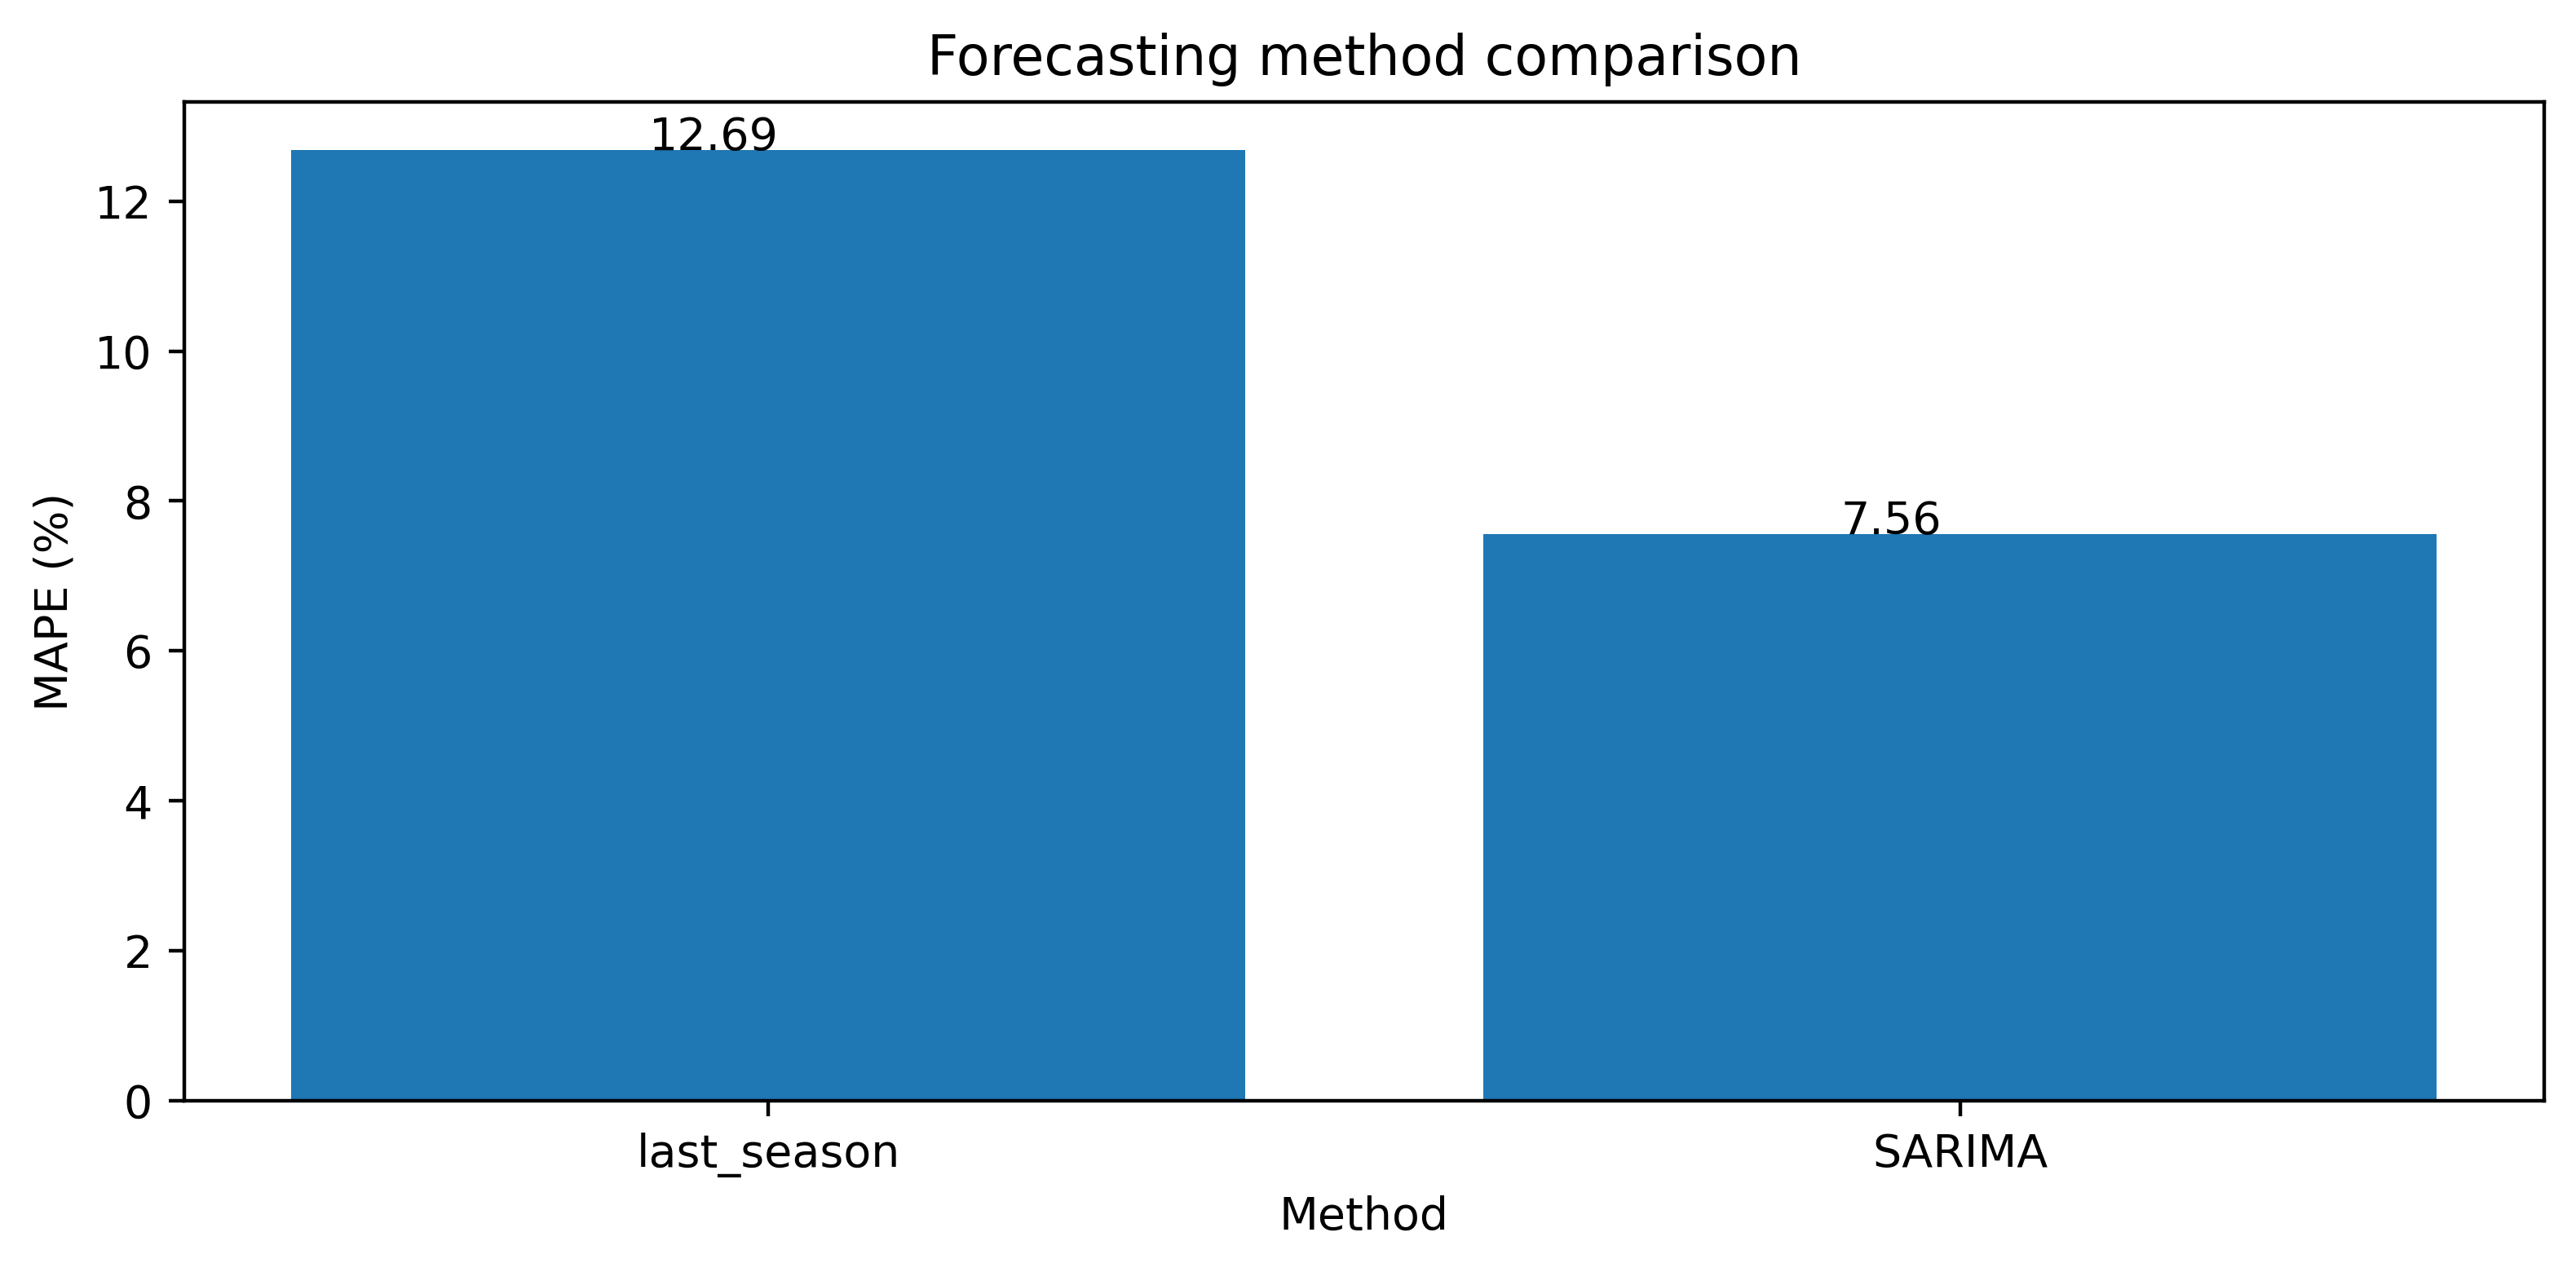

In [87]:
# comparing the mape of each model

mapes = [mape_last := mape(test.y, test.pred_last), mape_sarima := mape(test.y, test.pred_sarima)]

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(2), mapes)

# customizing the plot
for xpos, value in zip(range(2), mapes):
    plt.annotate(
        round(value, 2), (xpos - .1, value)
    )

ax.set(title='Forecasting method comparison', xlabel='Method', ylabel='MAPE (%)')

plt.xticks(
    range(2),
    'last_season SARIMA'.split()
)

plt.tight_layout();

On average the model was off by 7.56% up or down the observed value, in contrast the naive seasonal method has a MAPE of 12.69%, since the MAPE from the model is considerably lower than the one from the naive forecasting method my recommendation would be to use the model in production.